In [3]:
# In this project I'll try to explore the results of sentiment analysis with supervisioned machine learning technique

In [4]:
# preparing the environment
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE



In [5]:
# loading the csv dataset
df = pd.read_csv("reviews_data.csv")

In [6]:
# first check on the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


In [7]:
# I won't use the columns "Image_links", "Date" and "location", so I am dropping it
df.drop(columns=["Image_Links", "location", "Date"])


,name,Rating,Review
0,Helen,5.0,Amber and LaDonna at the Starbucks on Southwes...
1,Courtney,5.0,** at the Starbucks by the fire station on 436...
2,Daynelle,5.0,I just wanted to go out of my way to recognize...
3,Taylor,5.0,Me and my friend were at Starbucks and my card...
4,Tenessa,5.0,I’m on this kick of drinking 5 cups of warm wa...
...,...,...,...
845,Becky,NaN,I ordered two venti frappacino's without whipp...
846,Bob,NaN,No Review Text
847,Erik,NaN,"DEMANDED TIPS FROM ME, THEN MADE ME WAIT UNTIL..."
848,Andrew,NaN,No Review Text


In [8]:
# Replacing the columns for organization
df = df[["name", "Review", "Rating"]]
df

,name,Review,Rating
0,Helen,Amber and LaDonna at the Starbucks on Southwes...,5.0
1,Courtney,** at the Starbucks by the fire station on 436...,5.0
2,Daynelle,I just wanted to go out of my way to recognize...,5.0
3,Taylor,Me and my friend were at Starbucks and my card...,5.0
4,Tenessa,I’m on this kick of drinking 5 cups of warm wa...,5.0
...,...,...,...
845,Becky,I ordered two venti frappacino's without whipp...,NaN
846,Bob,No Review Text,NaN
847,Erik,"DEMANDED TIPS FROM ME, THEN MADE ME WAIT UNTIL...",NaN
848,Andrew,No Review Text,NaN


In [9]:
# checking for null data
df.isna().sum()

name        0
Review      0
Rating    145
dtype: int64

In [10]:
# "Rating" column has null data, in fact, 145 null data. Let's solve this issue, before applying the ML functions
# I don't have any information about this null data, how it was collected, and its full context. Therefore, I don't think I can replace it with median values, or use any other approach. In this case, I will take the approach of discarding this null data and starting the machine learning training without these 145 data rows.
df_filtered = df[df["Rating"].isnull() != True]

In [11]:
df_filtered

,name,Review,Rating
0,Helen,Amber and LaDonna at the Starbucks on Southwes...,5.0
1,Courtney,** at the Starbucks by the fire station on 436...,5.0
2,Daynelle,I just wanted to go out of my way to recognize...,5.0
3,Taylor,Me and my friend were at Starbucks and my card...,5.0
4,Tenessa,I’m on this kick of drinking 5 cups of warm wa...,5.0
...,...,...,...
700,Margaret,I ordered Via Starbucks coffee online. I recei...,1.0
701,Ric,"My name is Ric **, I am journalist by professi...",3.0
702,Jayne,"The bagel was ice cold, not cut and not toasted.",1.0
703,Norma,"In the morning of Monday, August 15, 2011, at ...",1.0


In [12]:
df_filtered.isna().sum()

name      0
Review    0
Rating    0
dtype: int64

In [13]:
# I have remembered that this Dataset has some "No Review Text" information. I will drop those columns too
df_noreview = df_filtered[df_filtered["Review"] == "No Review Text"]

In [14]:
df_noreview.value_counts()

name    Review          Rating
Donald  No Review Text  1.0       1
Sharon  No Review Text  2.0       1
Name: count, dtype: int64

In [15]:
df_filtered = df_filtered[df_filtered["Review"] != "No Review Text"]

In [16]:
df_filtered

,name,Review,Rating
0,Helen,Amber and LaDonna at the Starbucks on Southwes...,5.0
1,Courtney,** at the Starbucks by the fire station on 436...,5.0
2,Daynelle,I just wanted to go out of my way to recognize...,5.0
3,Taylor,Me and my friend were at Starbucks and my card...,5.0
4,Tenessa,I’m on this kick of drinking 5 cups of warm wa...,5.0
...,...,...,...
700,Margaret,I ordered Via Starbucks coffee online. I recei...,1.0
701,Ric,"My name is Ric **, I am journalist by professi...",3.0
702,Jayne,"The bagel was ice cold, not cut and not toasted.",1.0
703,Norma,"In the morning of Monday, August 15, 2011, at ...",1.0


In [17]:
df_test = df_filtered[df_filtered["Rating"] == 3]
df_test

,name,Review,Rating
32,Latasha,"In my opinion, I can't believe Starbucks has n...",3.0
58,Elizabeth,I am continually disappointed when going to St...,3.0
64,David,I walk to the Starbucks near my house every ot...,3.0
88,Brenda,The location where I go the employees are grea...,3.0
114,terri,Have been frequenting Starbucks for 30 years. ...,3.0
136,Ron,My favorite Starbucks items are frappuccinos. ...,3.0
278,Barbara,Good choices but need not to run out all sched...,3.0
307,Linda,"I would like the menu for lunch to be expand, ...",3.0
331,Wendy,I have not been there in a while. Last time I ...,3.0
332,Jack,Starbucks their daily coffee is good but not g...,3.0


In [18]:
# Ok, I've removed the NaN values. Now I need to normalize the "text review" data to apply supervised training.
import nltk
nltk.download('rslp')

[nltk_data] Error loading rslp: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [19]:
stemmer = RSLPStemmer()

stop_words = set(stopwords.words('english'))


def clean_review(text):
    if pd.isnull(text):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-záéíóúâêîôûãõç\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text.strip()

df_filtered["cleaned_reviews"] = df_filtered["Review"].apply(clean_review)
# Let's see the first rows
print(df_filtered[['Review', 'cleaned_reviews']].head())

                                              Review  \
0  Amber and LaDonna at the Starbucks on Southwes...   
1  ** at the Starbucks by the fire station on 436...   
2  I just wanted to go out of my way to recognize...   
3  Me and my friend were at Starbucks and my card...   
4  I’m on this kick of drinking 5 cups of warm wa...   

                                     cleaned_reviews  
0  amb ladonn starbuck southwest parkway alway wa...  
1  starbuck fir station altamont spring fl mad da...  
2  wanted go way recogniz starbuck employe billy ...  
3  friend starbuck card didnt work thankful work ...  
4  im kick drinking cup warm wat work instacart r...  


C:\Users\stiag\AppData\Local\Temp\ipykernel_4712\3372401901.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["cleaned_reviews"] = df_filtered["Review"].apply(clean_review)


In [20]:
# rearranging the columns
df_filtered = df_filtered[["name", "Review", "cleaned_reviews", "Rating"]]
df_filtered

,name,Review,cleaned_reviews,Rating
0,Helen,Amber and LaDonna at the Starbucks on Southwes...,amb ladonn starbuck southwest parkway alway wa...,5.0
1,Courtney,** at the Starbucks by the fire station on 436...,starbuck fir station altamont spring fl mad da...,5.0
2,Daynelle,I just wanted to go out of my way to recognize...,wanted go way recogniz starbuck employe billy ...,5.0
3,Taylor,Me and my friend were at Starbucks and my card...,friend starbuck card didnt work thankful work ...,5.0
4,Tenessa,I’m on this kick of drinking 5 cups of warm wa...,im kick drinking cup warm wat work instacart r...,5.0
...,...,...,...,...
700,Margaret,I ordered Via Starbucks coffee online. I recei...,ordered via starbuck coffe onlin received emai...,1.0
701,Ric,"My name is Ric **, I am journalist by professi...",nam ric journalist profession im sending lett ...,3.0
702,Jayne,"The bagel was ice cold, not cut and not toasted.",bagel ice cold cut toasted,1.0
703,Norma,"In the morning of Monday, August 15, 2011, at ...",morning monday august cowork stopped starbuck ...,1.0


In [48]:
# For now I think the Text pre-processing is complete! Now I want to separate "Rating" greater than 3 as positive from less than 3 as negative, and equal to 3 as neutral.
def sentiment_classifier(rating):
    if rating >= 3:
        return 'positive'
    elif rating < 3:
        return 'negative'
    



In [49]:
df_filtered

,name,Review,cleaned_reviews,Rating,sentiment_label
0,Helen,Amber and LaDonna at the Starbucks on Southwes...,amb ladonn starbuck southwest parkway alway wa...,5.0,positive
1,Courtney,** at the Starbucks by the fire station on 436...,starbuck fir station altamont spring fl mad da...,5.0,positive
2,Daynelle,I just wanted to go out of my way to recognize...,wanted go way recogniz starbuck employe billy ...,5.0,positive
3,Taylor,Me and my friend were at Starbucks and my card...,friend starbuck card didnt work thankful work ...,5.0,positive
4,Tenessa,I’m on this kick of drinking 5 cups of warm wa...,im kick drinking cup warm wat work instacart r...,5.0,positive
...,...,...,...,...,...
700,Margaret,I ordered Via Starbucks coffee online. I recei...,ordered via starbuck coffe onlin received emai...,1.0,negative
701,Ric,"My name is Ric **, I am journalist by professi...",nam ric journalist profession im sending lett ...,3.0,negative
702,Jayne,"The bagel was ice cold, not cut and not toasted.",bagel ice cold cut toasted,1.0,negative
703,Norma,"In the morning of Monday, August 15, 2011, at ...",morning monday august cowork stopped starbuck ...,1.0,negative


In [50]:
#Applying the function
df_filtered['sentiment_label'] = df_filtered["Rating"].apply(sentiment_classifier)

C:\Users\stiag\AppData\Local\Temp\ipykernel_4712\2093096143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment_label'] = df_filtered["Rating"].apply(sentiment_classifier)


In [51]:
print(df_filtered['sentiment_label'].value_counts())


sentiment_label
negative    548
positive    155
Name: count, dtype: int64


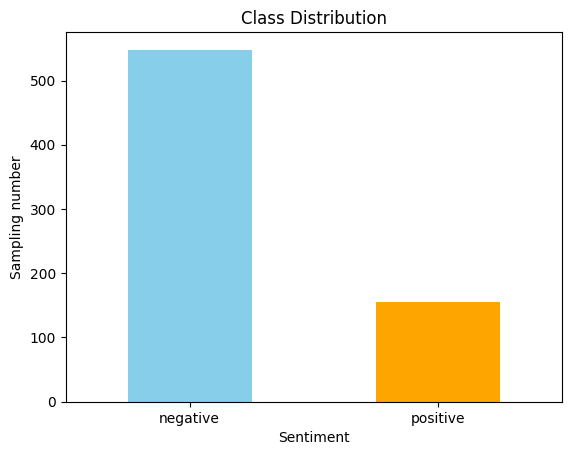

In [52]:
# Counting classes in the origial dataset
class_counts = df_filtered['sentiment_label'].value_counts()

# Plotting
class_counts.plot(kind='bar', title='Class Distribution', color=['skyblue', 'orange'])
plt.xlabel('Sentiment')
plt.ylabel('Sampling number')
plt.xticks(rotation=0)
plt.show()

In [26]:
# the dataset is unbalanced, now I need to study how should I balance the dataset before applying any supervised model

In [27]:
# I have done some research, and I see that in those cases, for Sentiment Analysis, it is pretty commom to implement the combination of random underampling for the majority class (in my case, negative comments) with oversampling (like SMOTE technique) for minority class  

In [59]:
# Vectorizing TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df_filtered['cleaned_reviews'])
y = df_filtered['sentiment_label']

In [60]:
# So let's undersample the majority class with Random Undersampling and SMOTE oversampling the minority class

# Step 1: Undersampling negatives to 155 comments (equal to positive comments)
rus = RandomUnderSampler(sampling_strategy={'negative': 155})
X_final, y_final = rus.fit_resample(X, y)

# # Step 2: Oversampling neutros (33) to 122 (equal to positive comments)
# smote = SMOTE(sampling_strategy={'neutral': 122})
# X_final, y_final = smote.fit_resample(X_rus, y_rus)

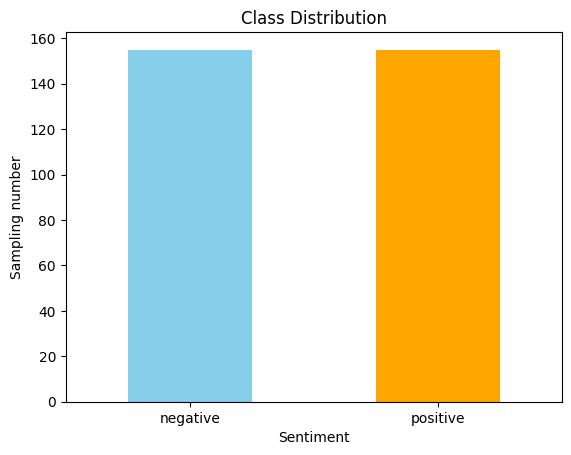

In [61]:
# Counting classes in the original dataset
class_counts = y_final.value_counts()

# Plotting
class_counts.plot(kind='bar', title='Class Distribution', color=['skyblue', 'orange'])
plt.xlabel('Sentiment')
plt.ylabel('Sampling number')
plt.xticks(rotation=0)
plt.show()

In [62]:
pd.Series(y_final).value_counts()

sentiment_label
negative    155
positive    155
Name: count, dtype: int64

In [63]:
# The dataset is balanced after random undersampling and oversampling techniques

In [64]:
# Now let's apply Logistic Regression model
data_collection = np.random.permutation(len(y_final))

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.77      0.90      0.83        30
    positive       0.89      0.75      0.81        32

    accuracy                           0.82        62
   macro avg       0.83      0.82      0.82        62
weighted avg       0.83      0.82      0.82        62



In [68]:
# 1. New phrases for verifying the model accuracy
new_phrases = [
    "Lady who works there would NOT let me use the restroom for customers today August 7, 2017. I gave her $20.00 to hold as a guarantee that was ordering a grande Soy Latte. She refused. Everyday for years I go to Starbucks at least once a day and spend at least $5.00 but this lady who was working refused to let me use the restroom. Terrible feeling. Somebody needs to talk to her and give her appropriate training.",   
]

# 2. Phrase cleaning
phrase_cleaned = [clean_review(phrase) for phrase in new_phrases]

# 3. Vectorizing the new phrases with the same vectorizer
phrases_vectorized = vectorizer.transform(phrase_cleaned)

# 4. Model predict
pred = model.predict(phrases_vectorized)

# 5. Show results
for phrase, pred in zip(new_phrases, pred):
    print(f"Frase: {phrase}\n→ Classification: {pred}\n")


Frase: Lady who works there would NOT let me use the restroom for customers today August 7, 2017. I gave her $20.00 to hold as a guarantee that was ordering a grande Soy Latte. She refused. Everyday for years I go to Starbucks at least once a day and spend at least $5.00 but this lady who was working refused to let me use the restroom. Terrible feeling. Somebody needs to talk to her and give her appropriate training.
→ Classification: negative

